In [1]:
%matplotlib inline

import pandas as pd
import critical_loads as cl
import matplotlib.pyplot as plt

plt.style.use('ggplot')

# Recalculating critical loads for water

Critical loads values for water (which are used as inputs to e.g. the SSWC and FAB models) were originally calculated by Tore using functions in the RESA2 packages `CL` and `CALKBLR`. Kari would like to generalise these calculations to make it easier to estimate critical loads based on raw data from other sites/catchments/regions. The critical loads calculations themselves are mostly implemented by the `CL.CLparamBLR` function, which in turn calls `CL.CLcalculations`. The latter of these has been documented in detail by Kari here:

    K:\Avdeling\317 Klima- og miljømodellering\KAU\Focal Centre\Data\CL script 23032015_notes.docx
    
Other functions within the `CALKBLR` package primarily perform unit conversions and matching of missing data etc.

## 1. Excel input template

To supply new data, use the Excel file in Excel named `input_template_critical_loads_water.xlsx` as a template. Users can enter raw data in a copy of this file and then use the fucntions in this notebook to (re-)calculate values for critical loads. **See the `readme` worksheet in the Excel file for details of the input data requirements**.

## 2. Re-calculate old critical loads

To date, the basic chemistry data used to estimate critical loads for water has been stored in the table `RESA2.TALEGREN_VALUES`. It is not clear what raw data were used to generate this table, but we are not going to change this at this stage. I have extracted basic data from this table and pasted it into a copy of the Excel template above. Results from the new code can then be compared to values in the view `RESA2.CLA`, which is where results from the old code are stored.

In [2]:
# Path to completed template
xl_path = r'../water_cls/water_cl_by_blr.xlsx'
df = cl.calculate_critical_loads_for_water(xl_path)

df.head()

,Region_id,Nimm_meq/m2/yr,Nupt_meq/m2/yr,rhoN_,Ffor_,CLrat_,BC0_ueq/l,BC0_magic_ueq/l,ANClimit_ueq/l,ANClimitOAA_ueq/l,...,Runoff_m/yr,ENO3_flux_meq/m2/yr,ECax_ueq/l,ECl_ueq/l,EMgx_ueq/l,ENax_ueq/l,ESO4x_ueq/l,ENO3_ueq/l,EKx_ueq/l,TOC_mg/l
0,58005004,3.3915,NaN,0.167960,0.95,0.05,NaN,NaN,NaN,NaN,...,1.238452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,58006001,3.3915,0.0,0.154958,0.95,0.05,27.975910,NaN,7.111359,5.702429,...,1.363338,35.518799,19.153974,251.057828,3.445895,6.176906,67.832487,26.052819,0.596049,0.4
2,58006002,3.3915,0.0,0.121113,0.95,0.05,26.781067,NaN,8.356418,6.405928,...,1.814182,27.840769,19.499878,160.789845,7.152406,0.000000,58.391800,15.346181,1.453609,0.8
3,58006003,3.3915,0.0,0.124403,0.95,0.05,18.087609,NaN,5.525898,4.177374,...,1.759601,25.119209,14.069508,186.177715,3.821796,0.000000,68.269042,14.275517,0.996627,0.6
4,58006004,3.3915,24.1,0.126937,0.95,0.05,17.502591,NaN,5.261902,3.782787,...,1.719479,36.819685,14.741462,141.043724,1.972872,0.000000,66.671747,21.413276,1.553285,0.8


## 3. Compare to Tore's values

`resa2_cla.csv` is a copy of the view `RESA2.CLA`, which stores the results from Tore's scripts. The code below renames columns in Tore's table to match the new workflow and then produces a grid-plot comparing old and new values.

In [3]:
# Strip units from new output
cols = ['_'.join(i.split('_')[:-1]) for i in df.columns]
df.columns = cols
df.rename({'Region':'Region_id'}, axis='columns', inplace=True)

# Read old results
old_df = pd.read_csv('../water_cls/resa2_cla.csv', sep=';', decimal=',')

# Cols to compare. Doesn't icnlude MAGIC, as input data are not available in the 
# format required for new workflow. Also doesn't compare water chemistry, as Tore's
# script output mg/l whereas the new workflow gives sea-salt corrected eq/l
comp_cols = ['Nupt', 'rhoN', 'BC0', 'ANClimit', 'ANClimitOAA', 'CLA', 'CLAOAA', 
             'CLminN', 'CLmaxN', 'CLmaxNoaa', 'CLmaxS', 'CLmaxSoaa', 'Runoff', 
             'ENO3_flux', 'TOC']

# Rename cols in old_df to match new output
old_df.rename({'BLR':'Region_id',
               'CLAOAAVAROAA':'CLAOAA',
               'NIMM':'Nimm',
               'NUPT':'Nupt',
               'RHON':'rhoN',
               'FFOR':'Ffor',
               'CLRAT':'CLrat',
               'CLMINN':'CLminN',
               'CLMAXN':'CLmaxN',
               'CLMAXNOAA':'CLmaxNoaa',
               'CLMAXS':'CLmaxS',
               'CLMAXSOAA':'CLmaxSoaa',
               'ANCVARLIMIT':'ANClimit',
               'ANCVARLIMITOAA':'ANClimitOAA',
               'Q2':'Runoff',
               'ENO3FL':'ENO3_flux',
              },
              axis='columns',
              inplace=True,
             )

# Convert runoff units to m/yr
old_df['Runoff'] = old_df['Runoff'] / 1000

# Join
df = df[['Region_id'] + comp_cols]
old_df = old_df[['Region_id'] + comp_cols]
comp_df = pd.merge(df, 
                   old_df, 
                   how='inner', 
                   on='Region_id',
                   suffixes=['_new', '_old'],
                  )

comp_df.head()              

,Region_id,Nupt_new,rhoN_new,BC0_new,ANClimit_new,ANClimitOAA_new,CLA_new,CLAOAA_new,CLminN_new,CLmaxN_new,...,CLA_old,CLAOAA_old,CLminN_old,CLmaxN_old,CLmaxNoaa_old,CLmaxS_old,CLmaxSoaa_old,Runoff_old,ENO3_flux_old,TOC_old
0,58006001,0.0,0.154958,27.975910,7.111359,5.702429,28.445436,28.512144,3.204124,40.399234,...,28.465742,28.533538,3.204124,40.425786,40.514435,28.987728,29.056767,1.363338,35.544,0.4
1,58006002,0.0,0.121113,26.781067,8.356418,6.405928,33.425670,32.029639,3.204124,45.228249,...,33.425795,32.029772,3.204124,45.228406,43.473268,33.886413,32.471152,1.814182,27.861,0.8
2,58006003,0.0,0.124403,18.087609,5.525898,4.177374,22.103593,20.886871,3.204124,31.098070,...,22.104827,20.888186,3.204124,31.099627,29.564269,22.418888,21.184960,1.759601,25.137,0.6
3,58006004,24.1,0.126937,17.502591,5.261902,3.782787,21.047610,18.913935,25.972633,52.611066,...,21.048040,18.914393,25.972633,52.611611,49.911208,21.354064,19.189395,1.719479,36.846,0.8
4,58006005,0.0,0.157986,21.490259,5.369813,4.092583,21.479250,20.462917,3.204124,31.391264,...,21.479371,20.463044,3.204124,31.391423,30.057701,21.882385,20.846989,1.332423,47.587,0.6


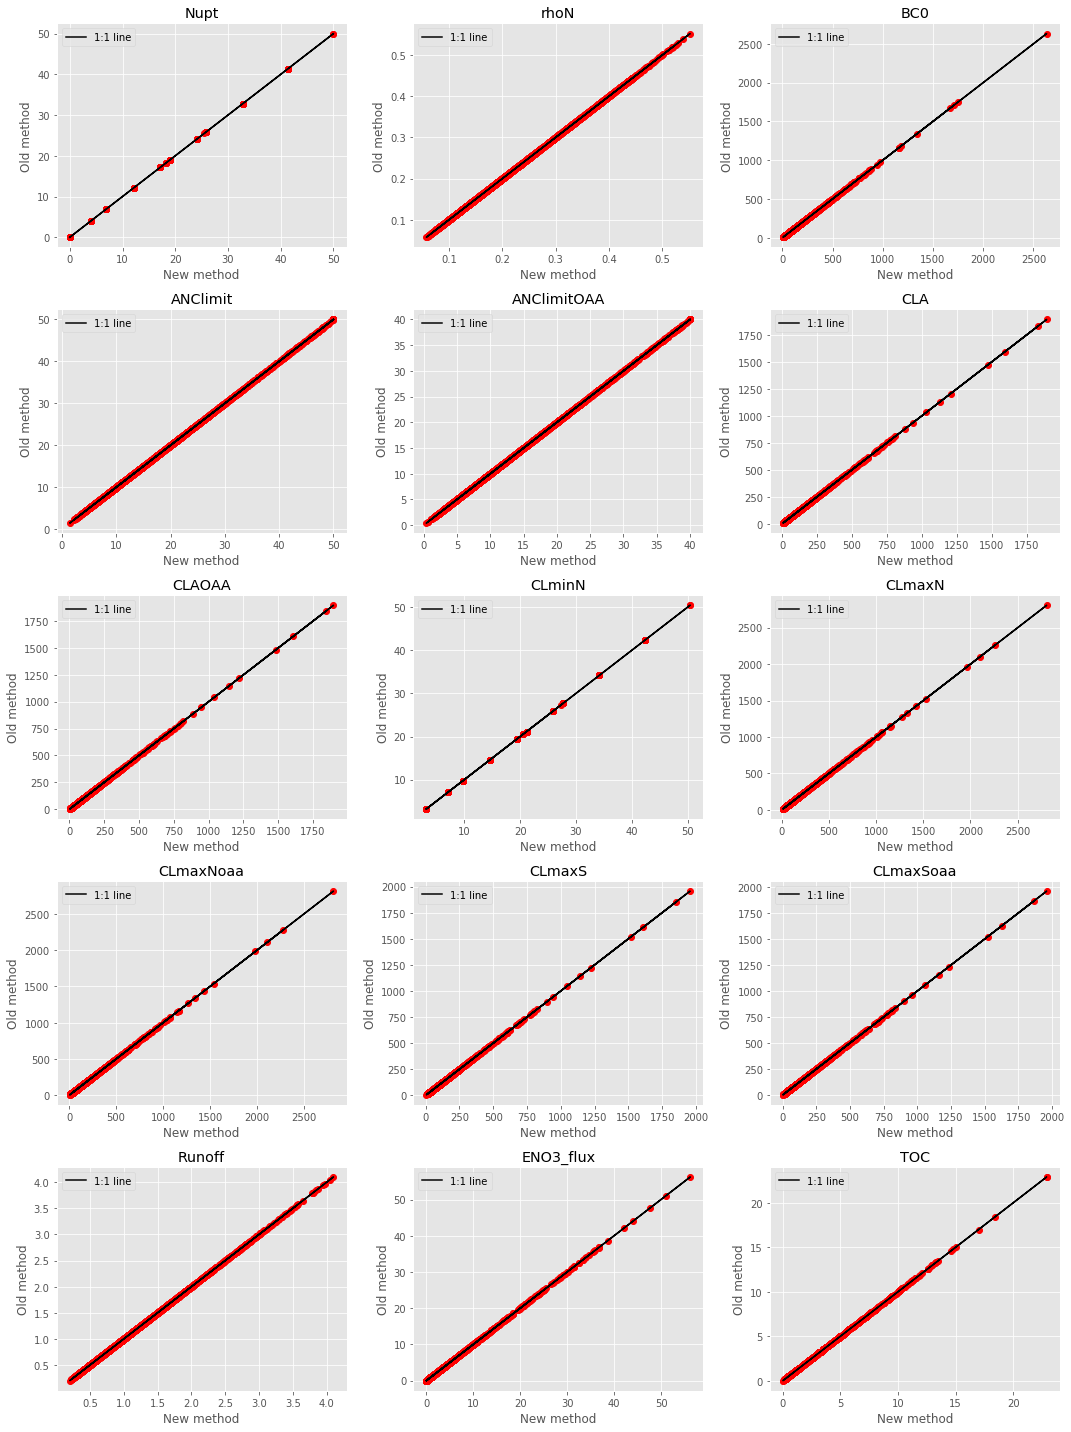

In [4]:
# Plot
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15,20))
axes = axes.flatten()

for idx, col in enumerate(comp_cols):
    axes[idx].plot(comp_df[col+'_new'], comp_df[col+'_old'], 'ro')
    axes[idx].plot(comp_df[col+'_new'], comp_df[col+'_new'], 'k-', label='1:1 line')
    axes[idx].legend()
    axes[idx].set_title(col)
    axes[idx].set_xlabel('New method')
    axes[idx].set_ylabel('Old method')
    
plt.tight_layout()    